Imports

In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src"))


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path
import gurobipy as gp
from gurobipy import GRB
from capital_budgeting_extended import read_projects, build_solve


ImportsLoad Data

In [3]:
base = Path('../')
csv_path = base / 'data' / 'projects_example.csv'
df = read_projects(csv_path)
df.head()


,proj_id,name,cost,benefit,region,type,requires,exclusive_group,labour,land,priority,social_score
0,P01,Route_Rurale_A,200000,350000,RegionA,Route,,INFRA1,50,100,2,78
1,P02,Ecole_Primaire_B,120000,180000,RegionB,Education,,INFRA2,30,40,3,85
2,P03,Hopital_Central_C,800000,1400000,RegionA,Sante,,INFRA3,200,500,1,95
3,P04,Station_Eau_D,250000,420000,RegionC,Eau,,INFRA1,60,150,2,82
4,P05,Renovation_Pont_E,180000,260000,RegionB,Route,P01,INFRA4,40,60,3,70


describead Data

In [4]:
df.describe(include='all')

,proj_id,name,cost,benefit,region,type,requires,exclusive_group,labour,land,priority,social_score
count,15,15,1.500000e+01,1.500000e+01,15,15,15,15,15.000000,15.000000,15.000000,15.000000
unique,15,15,NaN,NaN,4,8,3,8,NaN,NaN,NaN,NaN
top,P01,Route_Rurale_A,NaN,NaN,RegionA,Route,,INFRA1,NaN,NaN,NaN,NaN
freq,1,1,NaN,NaN,4,3,13,3,NaN,NaN,NaN,NaN
mean,NaN,NaN,3.860000e+05,6.393333e+05,NaN,NaN,NaN,NaN,173.333333,340.666667,2.200000,81.266667
std,NaN,NaN,3.661538e+05,6.472190e+05,NaN,NaN,NaN,NaN,255.906419,508.309055,0.774597,8.506020
min,NaN,NaN,9.000000e+04,1.200000e+05,NaN,NaN,NaN,NaN,15.000000,10.000000,1.000000,65.000000
25%,NaN,NaN,1.700000e+05,2.550000e+05,NaN,NaN,NaN,NaN,37.500000,55.000000,2.000000,76.000000
50%,NaN,NaN,2.500000e+05,4.200000e+05,NaN,NaN,NaN,NaN,60.000000,150.000000,2.000000,82.000000
75%,NaN,NaN,4.500000e+05,7.600000e+05,NaN,NaN,NaN,NaN,210.000000,375.000000,3.000000,87.000000


Correlation Heatmap 

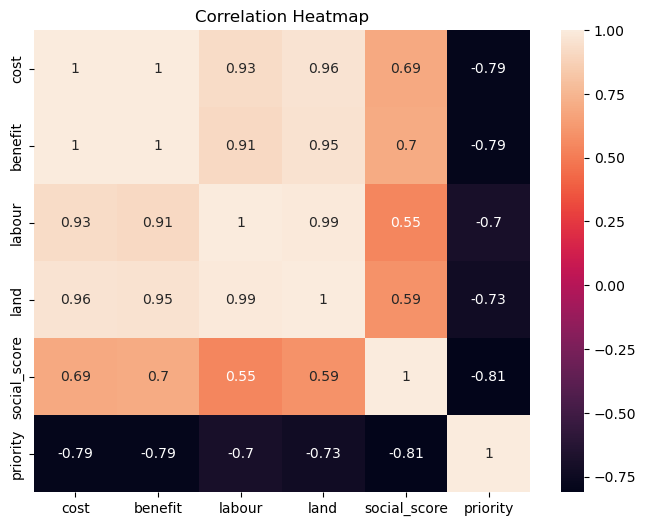

In [5]:
numeric_cols = ['cost','benefit','labour','land','social_score','priority']
corr = df[numeric_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True)
plt.title("Correlation Heatmap")
plt.show()


Function: Solve for any budget

In [6]:
def run_with_budget(B):
    res = build_solve(df,
                      budget=B,
                      resource_caps={'labour':2000,'land':4000},
                      groups_exclusive=None,
                      dependencies=None,
                      region_min_max=None,
                      K=None,
                      time_limit=10,
                      pool_solutions=0,
                      multi_crit_alpha=1.0)
    return res['solutions'][0]['obj'], len(res['solutions'][0]['selected'])


Budget Sensitivity Curve

Restricted license - for non-production use only - expires 2027-11-29
Set parameter TimeLimit to value 10
Set parameter PoolSearchMode to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (win64 - Windows 11.0 (26100.2))
Set parameter TimeLimit to value 10
Set parameter PoolSearchMode to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13650HX, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  10

Optimize a model with 3 rows, 15 columns and 45 nonzeros (Max)
Model fingerprint: 0xafc9b052
Model has 14 linear objective coefficients
Variable types: 0 continuous, 15 integer (15 binary)
Coefficient statistics:
  Matrix range     [1e+01, 2e+06]
  Objective range  [2e+04, 6e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+03, 3e+05]
Found heuristic solution: objective 59293.010753
Presolve remov

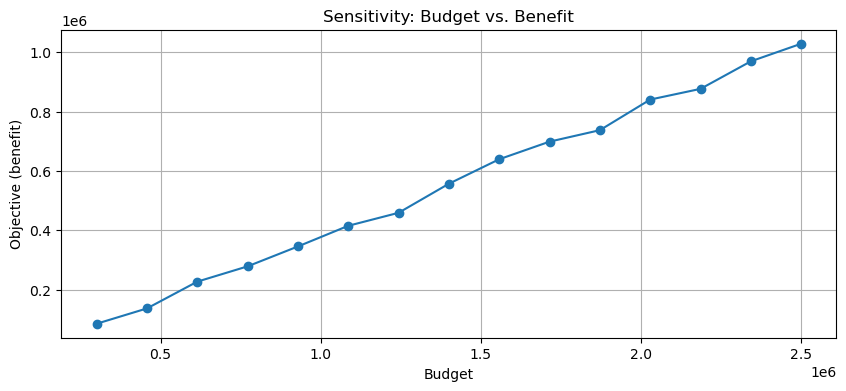

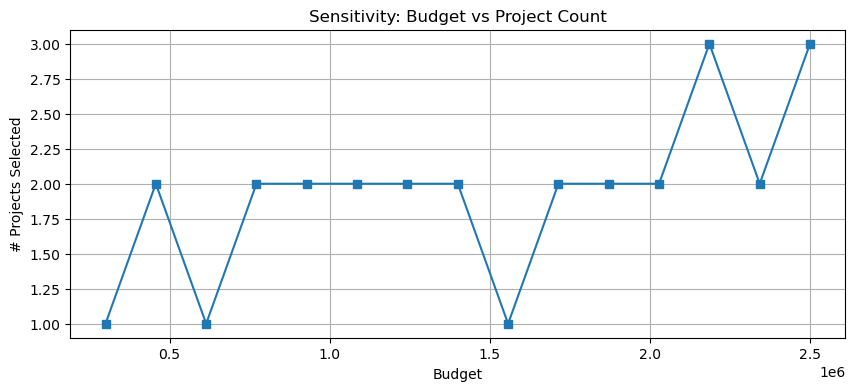

In [7]:
budgets = np.linspace(300000, 2500000, 15)
objs = []
counts = []

for B in budgets:
    obj, cnt = run_with_budget(B)
    objs.append(obj)
    counts.append(cnt)

plt.figure(figsize=(10,4))
plt.plot(budgets, objs, marker='o')
plt.xlabel("Budget")
plt.ylabel("Objective (benefit)")
plt.title("Sensitivity: Budget vs. Benefit")
plt.grid()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(budgets, counts, marker='s')
plt.xlabel("Budget")
plt.ylabel("# Projects Selected")
plt.title("Sensitivity: Budget vs Project Count")
plt.grid()
plt.show()


Multi-Objective Tradeoff Curve (α in [0,1])

Set parameter TimeLimit to value 10
Set parameter PoolSearchMode to value 0
Set parameter PoolSearchMode to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13650HX, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  10

Optimize a model with 3 rows, 15 columns and 45 nonzeros (Max)
Model fingerprint: 0x9f69e301
Model has 14 linear objective coefficients
Variable types: 0 continuous, 15 integer (15 binary)
Coefficient statistics:
  Matrix range     [1e+01, 2e+06]
  Objective range  [1e+05, 6e+05]
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13650HX, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  10

Optimize a model with 3 rows, 15 co

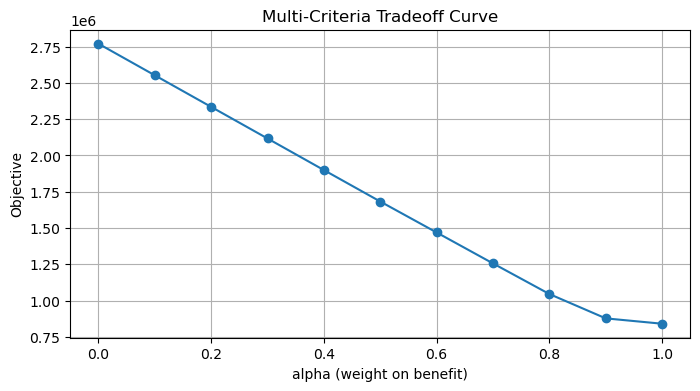

In [8]:
alphas = np.linspace(0,1,11)
objs2 = []
solutions2 = []

for a in alphas:
    res = build_solve(df,
                      budget=2000000,
                      resource_caps={'labour':2000,'land':4000},
                      groups_exclusive=None,
                      dependencies=None,
                      region_min_max=None,
                      time_limit=10,
                      pool_solutions=0,
                      multi_crit_alpha=a)
    sol = res['solutions'][0]
    objs2.append(sol['obj'])
    solutions2.append(sol['selected'])

plt.figure(figsize=(8,4))
plt.plot(alphas, objs2, marker='o')
plt.xlabel("alpha (weight on benefit)")
plt.ylabel("Objective")
plt.title("Multi-Criteria Tradeoff Curve")
plt.grid()
plt.show()


In [9]:
# robust build_solve with proper solution-pool settings and extraction
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

Solution Pool (Top-K Alternatives)

In [10]:
# Debugging snippet to paste into your notebook (after imports and df loaded)
res = build_solve(df,
                  budget=2000000,
                  resource_caps={'labour':2000,'land':4000},
                  groups_exclusive=None,
                  dependencies=None,
                  region_min_max=None,
                  time_limit=30,
                  pool_solutions=5,
                  multi_crit_alpha=1.0)

m = res.get('model', None)
print("Returned solutions (length):", len(res.get('solutions', [])))
if m is None:
    print("No model object returned.")
else:
    print("Model.Status:", m.Status)
    print("m.SolCount:", getattr(m, 'SolCount', 0))
    try:
        print("Params: PoolSearchMode =", m.Params.PoolSearchMode, 
              "PoolSolutions =", m.Params.PoolSolutions)
    except Exception as e:
        print("Could not read Params:", e)

    solcount = int(getattr(m, 'SolCount', 0))
    for s in range(min(solcount, 10)):
        # select solution s
        try:
            m.Params.SolutionNumber = s
        except Exception:
            try:
                m.setParam('SolutionNumber', s)
            except Exception:
                pass

        # objective for this pool solution
        pobj = getattr(m, 'PoolObjVal', None)
        print(f"--- Solution #{s} PoolObjVal={pobj} ---")
        # list variables with nonzero value in this pool solution
        for v in m.getVars():
            val = None
            if hasattr(v, 'Xn'):
                try:
                    val = v.Xn
                except Exception:
                    val = None
            if val is None:
                try:
                    val = v.X
                except Exception:
                    val = None
            if val is not None and val > 0.5:
                print(v.VarName, val)

Set parameter TimeLimit to value 30
Set parameter PoolSearchMode to value 0
Set parameter PoolSearchMode to value 2
Set parameter PoolSolutions to value 5
Set parameter PoolGap to value 1
Set parameter MIPFocus to value 1
Set parameter NumericFocus to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (win64 - Windows 11.0 (26100.2))
Set parameter PoolSearchMode to value 0
Set parameter PoolSearchMode to value 2
Set parameter PoolSolutions to value 5
Set parameter PoolGap to value 1
Set parameter MIPFocus to value 1
Set parameter NumericFocus to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13650HX, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  30
MIPFocus  1
NumericFocus  1
PoolSolutions  5
PoolSearchMode  2
PoolGap  1

Optimize a model with 3 rows, 15 columns and 45 nonzeros (Max)
Model fingerp

In [11]:
res_pool = build_solve(df,
          budget=2000000,
          resource_caps={'labour':2000,'land':4000},
          groups_exclusive=None,
          dependencies=None,
          region_min_max=None,
          time_limit=60,         # give it time
          pool_solutions=5,
          pool_gap=0.05,         # allow 5% worse solutions in the pool (tune)
          multi_crit_alpha=1.0)

for sol in res_pool['solutions']:
    print(f"Solution #{sol['sol_no']}  obj={sol['obj']:.2f}")
    print(", ".join(sol['selected']))
    print("----")


Set parameter TimeLimit to value 60
Set parameter PoolSearchMode to value 0
Set parameter PoolSearchMode to value 2
Set parameter PoolSolutions to value 5
Set parameter PoolGap to value 0.05
Set parameter MIPFocus to value 1
Set parameter NumericFocus to value 1
Set parameter PoolSearchMode to value 0
Set parameter PoolSearchMode to value 2
Set parameter PoolSolutions to value 5
Set parameter PoolGap to value 0.05
Set parameter MIPFocus to value 1
Set parameter NumericFocus to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13650HX, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  60
MIPFocus  1
NumericFocus  1
PoolSolutions  5
PoolSearchMode  2
PoolGap  0.05

Optimize a model with 3 rows, 15 columns and 45 nonzeros (Max)
Model fingerprint: 0x8de0e368
Model has 14 linear objective coefficients
Variable type

Regional Distribution of Best Solution

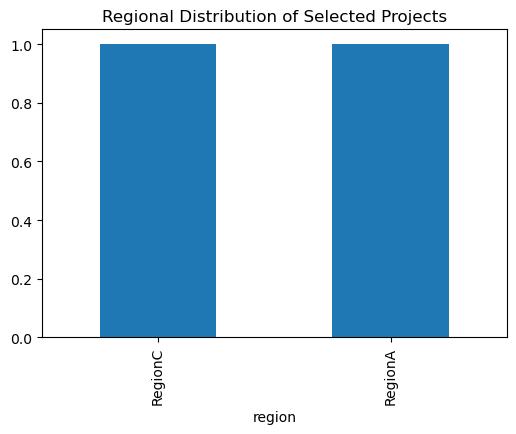

In [12]:
best = res_pool['solutions'][0]['selected']

region_counts = df[df['proj_id'].isin(best)]['region'].value_counts()

region_counts.plot(kind='bar', figsize=(6,4))
plt.title("Regional Distribution of Selected Projects")
plt.show()


In [13]:
# Paste this into one Jupyter code cell and run it.
import sys, os, importlib
# ensure src folder is on path (adjust if your notebook location differs)
sys.path.append(os.path.abspath("../src"))

# import the module object (may be cached)
import capital_budgeting_extended

# Reload to pick up recent edits
importlib.reload(capital_budgeting_extended)

# Now import the functions
from capital_budgeting_extended import read_projects, build_solve, enumerate_k_best

# quick smoke test
from pathlib import Path
df = read_projects(Path('../') / 'data' / 'projects_example.csv')
print("Module reloaded. enumerate_k_best present?:", hasattr(capital_budgeting_extended, 'enumerate_k_best'))

Module reloaded. enumerate_k_best present?: True


In [14]:
# Paste this whole block into a Jupyter code cell and run it.
from pathlib import Path
from capital_budgeting_extended import read_projects, build_solve, enumerate_k_best

# Load data
df = read_projects(Path('../') / 'data' / 'projects_example.csv')

budget = 2000000
resource_caps = {'labour': 2000, 'land': 4000}

print('--- Single solve (no pool) ---')
res1 = build_solve(
    df,
    budget=budget,
    resource_caps=resource_caps,
    groups_exclusive=None,
    dependencies=None,
    region_min_max=None,
    time_limit=30,
    pool_solutions=0,
    multi_crit_alpha=1.0
)

m1 = res1.get('model')
print('Returned solutions length (res1):', len(res1.get('solutions', [])))
if m1 is not None:
    print('Model.Status (res1):', m1.Status)
    print('m1.SolCount:', getattr(m1, 'SolCount', 'N/A'))

if res1.get('solutions'):
    s0 = res1['solutions'][0]
    print('res1 selected (count):', len(s0.get('selected', [])))
    print('res1 obj:', s0.get('obj'))
    print('res1 selected list:', s0.get('selected'))
else:
    print('No solution in res1')

print('\n--- Second solve with exclusion of first solution (explicit test) ---')
if res1.get('solutions'):
    first_sel = res1['solutions'][0]['selected']
    res2 = build_solve(
        df,
        budget=budget,
        resource_caps=resource_caps,
        groups_exclusive=None,
        dependencies=None,
        region_min_max=None,
        time_limit=30,
        pool_solutions=0,
        multi_crit_alpha=1.0,
        exclude_sets=[first_sel]
    )
    m2 = res2.get('model')
    print('Returned solutions length (res2):', len(res2.get('solutions', [])))
    if m2 is not None:
        print('Model.Status (res2):', m2.Status)
        print('m2.SolCount:', getattr(m2, 'SolCount', 'N/A'))
        try:
            # safe extraction of constraint names (handle attribute name differences)
            cons = []
            for c in m2.getConstrs():
                name = getattr(c, 'ConstrName', None) or getattr(c, 'constrName', None) or getattr(c, 'VarName', None)
                cons.append(name)
            print('Constraints in m2 (sample):', cons[:10])
        except Exception as e:
            print('Could not list constraints:', e)
    if res2.get('solutions'):
        s1 = res2['solutions'][0]
        print('res2 selected (count):', len(s1.get('selected', [])))
        print('res2 obj:', s1.get('obj'))
        print('res2 selected list:', s1.get('selected'))
    else:
        print('No solutions returned on second solve; model may be infeasible under exclusion or no alternative exists')
else:
    print('No initial solution found; cannot test exclusion')

print('\n--- Try enumerate_k_best (k=3) ---')
res_k = enumerate_k_best(
    df,
    budget=budget,
    resource_caps=resource_caps,
    groups_exclusive=None,
    dependencies=None,
    region_min_max=None,
    K=None,
    time_limit=30,
    k=3,
    time_per_solve=30,
    multi_crit_alpha=1.0
)

print('enumerate_k_best returned:', len(res_k.get('solutions', [])), 'solutions')
for sol in res_k.get('solutions', []):
    print(f"sol_no={sol.get('sol_no')} obj={sol.get('obj')}")
    print(sol.get('selected'))

--- Single solve (no pool) ---
Set parameter TimeLimit to value 30
Set parameter PoolSearchMode to value 0
Set parameter PoolSearchMode to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13650HX, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  30

Optimize a model with 3 rows, 15 columns and 45 nonzeros (Max)
Model fingerprint: 0x8de0e368
Model has 14 linear objective coefficients
Variable types: 0 continuous, 15 integer (15 binary)
Coefficient statistics:
  Matrix range     [1e+01, 2e+06]
  Objective range  [2e+04, 6e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+03, 2e+06]
Found heuristic solution: objective 595508.06452
Presolve removed 2 rows and 1 columns
Presolve time: 0.00s
Presolved: 1 rows, 14 columns, 14 nonzeros
Variable types: 0 continuous, 14 integer (14 binary)

Root relaxation

In [15]:
# TEST: Verify the fix is loaded
import sys, os, importlib

# Remove old module from cache if it exists
if 'capital_budgeting_extended' in sys.modules:
    del sys.modules['capital_budgeting_extended']

sys.path.insert(0, os.path.abspath("../src"))

# Fresh import
from capital_budgeting_extended import build_solve, read_projects
from pathlib import Path

# Load data
df = read_projects(Path('../') / 'data' / 'projects_example.csv')

# TEST 1: pool_solutions=0 should return ONLY 1 solution
print("=" * 60)
print("TEST 1: pool_solutions=0 (should return 1 solution)")
print("=" * 60)
res = build_solve(
    df,
    budget=2000000,
    resource_caps={'labour': 2000, 'land': 4000},
    time_limit=30,
    pool_solutions=0
)
print(f"Number of solutions returned: {len(res['solutions'])}")
print(f"Solution 0: {len(res['solutions'][0]['selected'])} projects, obj={res['solutions'][0]['obj']:.2f}")

# TEST 2: pool_solutions=5 should return UP TO 5 solutions
print("\n" + "=" * 60)
print("TEST 2: pool_solutions=5 (should return up to 5 solutions)")
print("=" * 60)
res = build_solve(
    df,
    budget=2000000,
    resource_caps={'labour': 2000, 'land': 4000},
    time_limit=30,
    pool_solutions=5
)
print(f"Number of solutions returned: {len(res['solutions'])}")
for i, sol in enumerate(res['solutions']):
    print(f"  Solution {i}: {len(sol['selected'])} projects, obj={sol['obj']:.2f}")

TEST 1: pool_solutions=0 (should return 1 solution)
Set parameter TimeLimit to value 30
Set parameter PoolSearchMode to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (win64 - Windows 11.0 (26100.2))
Set parameter PoolSearchMode to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (win64 - Windows 11.0 (26100.2))


CPU model: 13th Gen Intel(R) Core(TM) i7-13650HX, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  30

Optimize a model with 3 rows, 15 columns and 45 nonzeros (Max)
Model fingerprint: 0x8de0e368
Model has 14 linear objective coefficients
Variable types: 0 continuous, 15 integer (15 binary)
Coefficient statistics:
  Matrix range     [1e+01, 2e+06]
  Objective range  [2e+04, 6e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+03, 2e+06]
Found heuristic solution: objective 595508.06452
Presolve removed 2 rows and 1 columns
Presolve time: 0.00s
Presolve

In [16]:
# Diagnostic: recharge le module et affiche exactement ce qui a été renvoyé
import sys, os, importlib
from pathlib import Path

# assure le dossier src sur sys.path
root = os.path.abspath("../src")
if root not in sys.path:
    sys.path.insert(0, root)

# reload propre du module
if 'capital_budgeting_extended' in sys.modules:
    del sys.modules['capital_budgeting_extended']
import capital_budgeting_extended
importlib.reload(capital_budgeting_extended)
from capital_budgeting_extended import read_projects, build_solve

# charge les données
df = read_projects(Path('../') / 'data' / 'projects_example.csv')

# appel de diagnostic: pool_solutions=2
res = build_solve(
    df,
    budget=2000000,
    resource_caps={'labour':2000, 'land':4000},
    time_limit=30,
    pool_solutions=2,
    pool_gap=0.05
)

m = res.get('model')
print("=== Model / Params ===")
if m is None:
    print("Model object: None (erreur possible)")
else:
    try:
        print("PoolSearchMode =", m.Params.PoolSearchMode)
    except Exception as e:
        print("PoolSearchMode: could not read (", e, ")")
    try:
        print("PoolSolutions  =", m.Params.PoolSolutions)
    except Exception as e:
        print("PoolSolutions: could not read (", e, ")")
    try:
        print("PoolGap        =", m.Params.PoolGap)
    except Exception as e:
        print("PoolGap: could not read (", e, ")")
    try:
        print("SolCount (m.SolCount) =", getattr(m, 'SolCount', 'N/A'))
    except Exception as e:
        print("SolCount read error:", e)

sols = res.get('solutions', [])
print("\n=== Res structure ===")
print("len(res['solutions']) =", len(sols))
for i, s in enumerate(sols):
    sel = s.get('selected', [])
    print(f"  entry {i}: sol_no={s.get('sol_no')}  obj={s.get('obj')}  #projects={len(sel)}")
    print("    selected:", sel)

# extra check: union of all selected projects across returned solutions
union = set()
for s in sols:
    union.update(s.get('selected', []))
print("\nUnion of projects across returned solutions (len):", len(union))
print(sorted(list(union)))

Set parameter TimeLimit to value 30
Set parameter PoolSearchMode to value 0
Set parameter PoolSearchMode to value 2
Set parameter PoolSolutions to value 2
Set parameter PoolGap to value 0.05
Set parameter MIPFocus to value 1
Set parameter NumericFocus to value 1
Set parameter PoolSearchMode to value 0
Set parameter PoolSearchMode to value 2
Set parameter PoolSolutions to value 2
Set parameter PoolGap to value 0.05
Set parameter MIPFocus to value 1
Set parameter NumericFocus to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13650HX, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  30
MIPFocus  1
NumericFocus  1
PoolSolutions  2
PoolSearchMode  2
PoolGap  0.05

Optimize a model with 3 rows, 15 columns and 45 nonzeros (Max)
Model fingerprint: 0x8de0e368
Model has 14 linear objective coefficients
Variable type

In [17]:
# Diagnostic: fresh import, run and print what build_solve returns (includes pool_meta)
import sys, os, importlib
from pathlib import Path

# force fresh import from src
if 'capital_budgeting_extended' in sys.modules:
    del sys.modules['capital_budgeting_extended']
sys.path.insert(0, os.path.abspath("../src"))

import importlib, capital_budgeting_extended
importlib.reload(capital_budgeting_extended)
from capital_budgeting_extended import read_projects, build_solve, enumerate_k_best

df = read_projects(Path('../') / 'data' / 'projects_example.csv')

res = build_solve(
    df,
    budget=2000000,
    resource_caps={'labour':2000, 'land':4000},
    time_limit=30,
    pool_solutions=2,
    pool_gap=0.05
)

print("=== top-level info ===")
print("len(res['solutions']) =", len(res.get('solutions', [])))
print("pool_meta:", res.get('pool_meta'))
print()

for i, s in enumerate(res.get('solutions', [])):
    sel = s.get('selected', [])
    print(f"entry {i}: sol_no={s.get('sol_no')}  obj={s.get('obj')}  #projects={len(sel)}")
    print("    selected:", sel)

# union
union = set()
for s in res.get('solutions', []):
    union.update(s.get('selected', []))
print()
print("Union of projects across returned solutions (len):", len(union))
print(sorted(list(union)))

Set parameter TimeLimit to value 30
Set parameter PoolSearchMode to value 0
Set parameter PoolSearchMode to value 2
Set parameter PoolSolutions to value 2
Set parameter PoolGap to value 0.05
Set parameter MIPFocus to value 1
Set parameter NumericFocus to value 1
Set parameter PoolSearchMode to value 0
Set parameter PoolSearchMode to value 2
Set parameter PoolSolutions to value 2
Set parameter PoolGap to value 0.05
Set parameter MIPFocus to value 1
Set parameter NumericFocus to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13650HX, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  30
MIPFocus  1
NumericFocus  1
PoolSolutions  2
PoolSearchMode  2
PoolGap  0.05

Optimize a model with 3 rows, 15 columns and 45 nonzeros (Max)
Model fingerprint: 0x8de0e368
Model has 14 linear objective coefficients
Variable type

In [18]:
# QUICK TEST: Can we find an alternative when excluding [P06, P07]?
import sys, os, importlib
from pathlib import Path

if 'capital_budgeting_extended' in sys.modules:
    del sys.modules['capital_budgeting_extended']
sys.path.insert(0, os.path.abspath("../src"))
import importlib, capital_budgeting_extended
importlib.reload(capital_budgeting_extended)
from capital_budgeting_extended import build_solve, read_projects

df = read_projects(Path('../') / 'data' / 'projects_example.csv')

print("=== Solve 1: baseline (no exclusion) ===")
res1 = build_solve(df, budget=2000000, resource_caps={'labour':2000, 'land':4000}, time_limit=30, pool_solutions=0)
sol1 = res1['solutions'][0]
print("Solution 1:", sol1['selected'], "obj=", sol1['obj'])

print("\n=== Solve 2: exclude solution 1 ===")
res2 = build_solve(df, budget=2000000, resource_caps={'labour':2000, 'land':4000}, 
                   time_limit=30, pool_solutions=0, exclude_sets=[sol1['selected']])
sol2 = res2['solutions'][0] if res2['solutions'] else None
if sol2:
    print("Solution 2:", sol2['selected'], "obj=", sol2['obj'])
    if set(sol2['selected']) != set(sol1['selected']):
        print("✓ DIFFERENT from solution 1")
    else:
        print("✗ SAME as solution 1 (exclusion constraint not working!)")
else:
    print("✗ No solution found (model infeasible under exclusion)")

print("\n=== Solve 3: exclude both previous ===")
if sol2:
    res3 = build_solve(df, budget=2000000, resource_caps={'labour':2000, 'land':4000}, 
                       time_limit=30, pool_solutions=0, exclude_sets=[sol1['selected'], sol2['selected']])
    sol3 = res3['solutions'][0] if res3['solutions'] else None
    if sol3:
        print("Solution 3:", sol3['selected'], "obj=", sol3['obj'])
    else:
        print("✗ No solution 3 found")

=== Solve 1: baseline (no exclusion) ===
Set parameter TimeLimit to value 30
Set parameter PoolSearchMode to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (win64 - Windows 11.0 (26100.2))
Set parameter PoolSearchMode to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13650HX, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  30

Optimize a model with 3 rows, 15 columns and 45 nonzeros (Max)
Model fingerprint: 0x8de0e368
Model has 14 linear objective coefficients
Variable types: 0 continuous, 15 integer (15 binary)
Coefficient statistics:
  Matrix range     [1e+01, 2e+06]
  Objective range  [2e+04, 6e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+03, 2e+06]
Found heuristic solution: objective 595508.06452
Presolve removed 2 rows and 1 columns
Presolve time: 0.00s
Presolved: 1 rows, 1

In [19]:
# FINAL TEST: pool_solutions=3 should now return 3 distinct solutions via fallback enumeration
import sys, os, importlib
from pathlib import Path

if 'capital_budgeting_extended' in sys.modules:
    del sys.modules['capital_budgeting_extended']
sys.path.insert(0, os.path.abspath("../src"))
import importlib, capital_budgeting_extended
importlib.reload(capital_budgeting_extended)
from capital_budgeting_extended import build_solve, read_projects

df = read_projects(Path('../') / 'data' / 'projects_example.csv')

print("Testing pool_solutions=3 with auto-fallback to K-best enumeration")
print("=" * 70)
res = build_solve(
    df,
    budget=2000000,
    resource_caps={'labour':2000, 'land':4000},
    time_limit=30,
    pool_solutions=3,
    pool_gap=0.05,
    multi_crit_alpha=1.0
)

print(f"\nReturned {len(res['solutions'])} solutions:")
for i, sol in enumerate(res['solutions']):
    print(f"\n  Solution {i+1}: obj={sol['obj']:.0f}")
    print(f"    selected: {sorted(sol['selected'])}")
    print(f"    # projects: {len(sol['selected'])}")

# Check they are distinct
selections = [tuple(sorted(s['selected'])) for s in res['solutions']]
unique_count = len(set(selections))
print(f"\n✓ DISTINCT solutions: {unique_count} / {len(selections)}")

if len(res['solutions']) >= 3:
    print("✓ SUCCESS: Got 3 or more distinct solutions via fallback!")
else:
    print(f"⚠ Got {len(res['solutions'])} solutions (less than 3 requested)")

Testing pool_solutions=3 with auto-fallback to K-best enumeration
Set parameter TimeLimit to value 30
Set parameter PoolSearchMode to value 0
Set parameter PoolSearchMode to value 2
Set parameter PoolSolutions to value 3
Set parameter PoolGap to value 0.05
Set parameter MIPFocus to value 1
Set parameter NumericFocus to value 1
Set parameter TimeLimit to value 30
Set parameter PoolSearchMode to value 0
Set parameter PoolSearchMode to value 2
Set parameter PoolSolutions to value 3
Set parameter PoolGap to value 0.05
Set parameter MIPFocus to value 1
Set parameter NumericFocus to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13650HX, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  30
MIPFocus  1
NumericFocus  1
PoolSolutions  3
PoolSearchMode  2
PoolGap  0.05

Optimize a model with 3 rows, 15 columns and 45